In [3]:
#  std

import pandas as pd
import numpy as np
import re

# ===========================================
# 1. 载入原始 Speed Dating 数据
# ===========================================
df = pd.read_csv('data/Speed Dating Data.csv', encoding='latin1')
print("Raw data loaded:", df.shape)

# ===========================================
# 2. 定义属性（6 个核心特质）
# ===========================================
bases = ['attr','fun','intel','like','sinc','amb']

# ===========================================
# 3. 定义三个阶段
# ===========================================
stage_patterns = {
    'Stage1': [r'1$', r'1_'],
    'Stage2': [r'2$', r'3$', r'4$', r'5$'],  # 对话后各次打分
    'Final':  [r'^attr$|^fun$|^intel$|^sinc$|^like$|^amb$']  # 最终评分
}

# 帮助函数：找出属于某个 base 的所有 Stage1/Stage2/Final 列
def find_and_group_cols(df, base):
    cols = [c for c in df.columns if c.lower().startswith(base.lower())]
    groups = {'Stage1':[], 'Stage2':[], 'Final':[]}

    for c in cols:
        assigned = False
        for st, pats in stage_patterns.items():
            for p in pats:
                if re.search(p, c):
                    groups[st].append(c)
                    assigned = True
                    break
            if assigned:
                break
        if not assigned:
            # 默认归入 Stage2（如 attr3_x 型）
            groups['Stage2'].append(c)

    # 最终评分（如 attr, fun ...）
    if base in df.columns:
        groups['Final'].append(base)

    return groups

# ===========================================
# 4. 构建 std
# ===========================================
std = pd.DataFrame()
std[['iid','pid','match']] = df[['iid','pid','match']]

for b in bases:
    grouped = find_and_group_cols(df, b)
    for st in ['Stage1','Stage2','Final']:
        colname = f'{b}_{st}'
        cols = grouped.get(st, [])
        if cols:
            std[colname] = df[cols].astype(float).mean(axis=1, skipna=True)
        else:
            std[colname] = np.nan

print("Standardized dataset (std) built. Shape =", std.shape)
std.head()


Raw data loaded: (8378, 195)
Standardized dataset (std) built. Shape = (8378, 21)


,iid,pid,match,attr_Stage1,attr_Stage2,attr_Final,fun_Stage1,fun_Stage2,fun_Final,intel_Stage1,...,intel_Final,like_Stage1,like_Stage2,like_Final,sinc_Stage1,sinc_Stage2,sinc_Final,amb_Stage1,amb_Stage2,amb_Final
0,1,11.0,0,18.088,5.666667,6.0,16.044,7.333333,7.0,15.378,...,7.0,NaN,7.0,7.0,16.934,7.333333,9.0,10.622,7.000000,6.0
1,1,12.0,0,18.088,6.000000,7.0,16.044,7.000000,8.0,15.378,...,7.0,NaN,8.0,7.0,16.934,7.333333,8.0,10.622,6.666667,5.0
2,1,13.0,1,18.088,7.000000,5.0,16.044,8.000000,8.0,15.378,...,9.0,NaN,10.0,7.0,16.934,8.000000,8.0,10.622,7.666667,5.0
3,1,14.0,1,18.088,6.000000,7.0,16.044,7.333333,7.0,15.378,...,8.0,NaN,7.0,7.0,16.934,7.333333,6.0,10.622,7.333333,6.0
4,1,15.0,1,18.088,6.333333,5.0,16.044,6.666667,7.0,15.378,...,7.0,NaN,8.0,6.0,16.934,7.000000,6.0,10.622,7.333333,6.0


In [14]:
import sys
!{sys.executable} -m pip install seaborn -i https://mirrors.aliyun.com/pypi/simple/


Looking in indexes: https://mirrors.aliyun.com/pypi/simple/



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**Dyad Interaction Stream（双人关系轨迹线）**

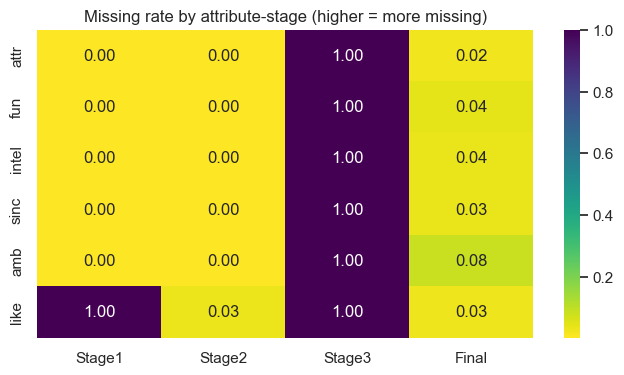

Top complete (converged-like): [(1, 11), (1, 12), (1, 14), (1, 19), (2, 20)]
Top divergent: [(324, 332), (354, 361), (466, 485), (526, 548), (27, 44)]


In [15]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# use std from version2 (standardized)
# compute missing rates per (base x stage)
bases = ['attr','fun','intel','sinc','amb','like']
stages = ['Stage1','Stage2','Stage3','Final']
missing = pd.DataFrame(index=bases, columns=stages, dtype=float)

for b in bases:
    for s in stages:
        col = f'{b}_{s}'
        if col in std.columns:
            missing.loc[b,s] = std[col].isna().mean()
        else:
            missing.loc[b,s] = 1.0

plt.figure(figsize=(8,4))
sns.heatmap(missing.astype(float), annot=True, fmt='.2f', cmap='viridis_r')
plt.title('Missing rate by attribute-stage (higher = more missing)')
plt.show()

# === Auto-select representative dyads ===
# compute 'final delta' (difference at Final stage)
def final_delta(std_row_A, std_row_B, base='attr'):
    a = std_row_A.get(f'{base}_Final'); b = std_row_B.get(f'{base}_Final')
    if pd.isna(a) or pd.isna(b): return np.nan
    return abs(float(a)-float(b))

# build list of reciprocal dyads (from std)
pairs = []
rows = std.dropna(subset=['pid'])
for _,r in rows.iterrows():
    A,B = int(r['iid']), int(r['pid'])
    if any(x== (B,A) for x in pairs): continue
    if ((std['iid']==B)&(std['pid']==A)).any():
        pairs.append((A,B))

# compute completeness score and final delta for each pair
records=[]
for A,B in pairs:
    rA = std[(std['iid']==A)&(std['pid']==B)].iloc[0]
    rB = std[(std['iid']==B)&(std['pid']==A)].iloc[0]
    # completeness: average non-null stages across bases
    comp = 0
    for b in bases:
        comp += sum(pd.notna(rA.get(f'{b}_{s}')) for s in stages) + sum(pd.notna(rB.get(f'{b}_{s}')) for s in stages)
    comp = comp / (2*len(bases)*len(stages))
    delta = final_delta(rA, rB, base='attr')
    records.append({'pair':(A,B),'completeness':comp,'final_delta':delta})
recdf = pd.DataFrame(records).dropna(subset=['final_delta']).sort_values(['completeness','final_delta'], ascending=[False, True])

# pick top complete (small delta → converged), top divergent, and mixed
top_complete = recdf.sort_values(['completeness','final_delta'], ascending=[False, True]).head(5)
top_divergent = recdf.sort_values(['final_delta','completeness'], ascending=[False, False]).head(5)

print("Top complete (converged-like):", list(top_complete['pair']))
print("Top divergent:", list(top_divergent['pair']))


In [17]:
# 准备：通用函数（必须先运行）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

bases = ['attr','fun','intel','like','sinc','amb']
stages = ['Stage1','Stage2','Final']

# 提取 A→B 和 B→A 的平均
def get_mean_by_stage(std, base):
    return [
        std[f"{base}_Stage1"].mean(),
        std[f"{base}_Stage2"].mean(),
        std[f"{base}_Final"].mean()
    ]

# 分别获取 男→女 女→男（iid 性别: gender, 0=女,1=男）
df = pd.read_csv('data/Speed Dating Data.csv', encoding='latin1')
gender = df[['iid','gender']].drop_duplicates().set_index('iid')['gender']
std = std.merge(gender, on='iid', how='left', suffixes=('','_gender_iid'))
gender_dict = gender.to_dict()


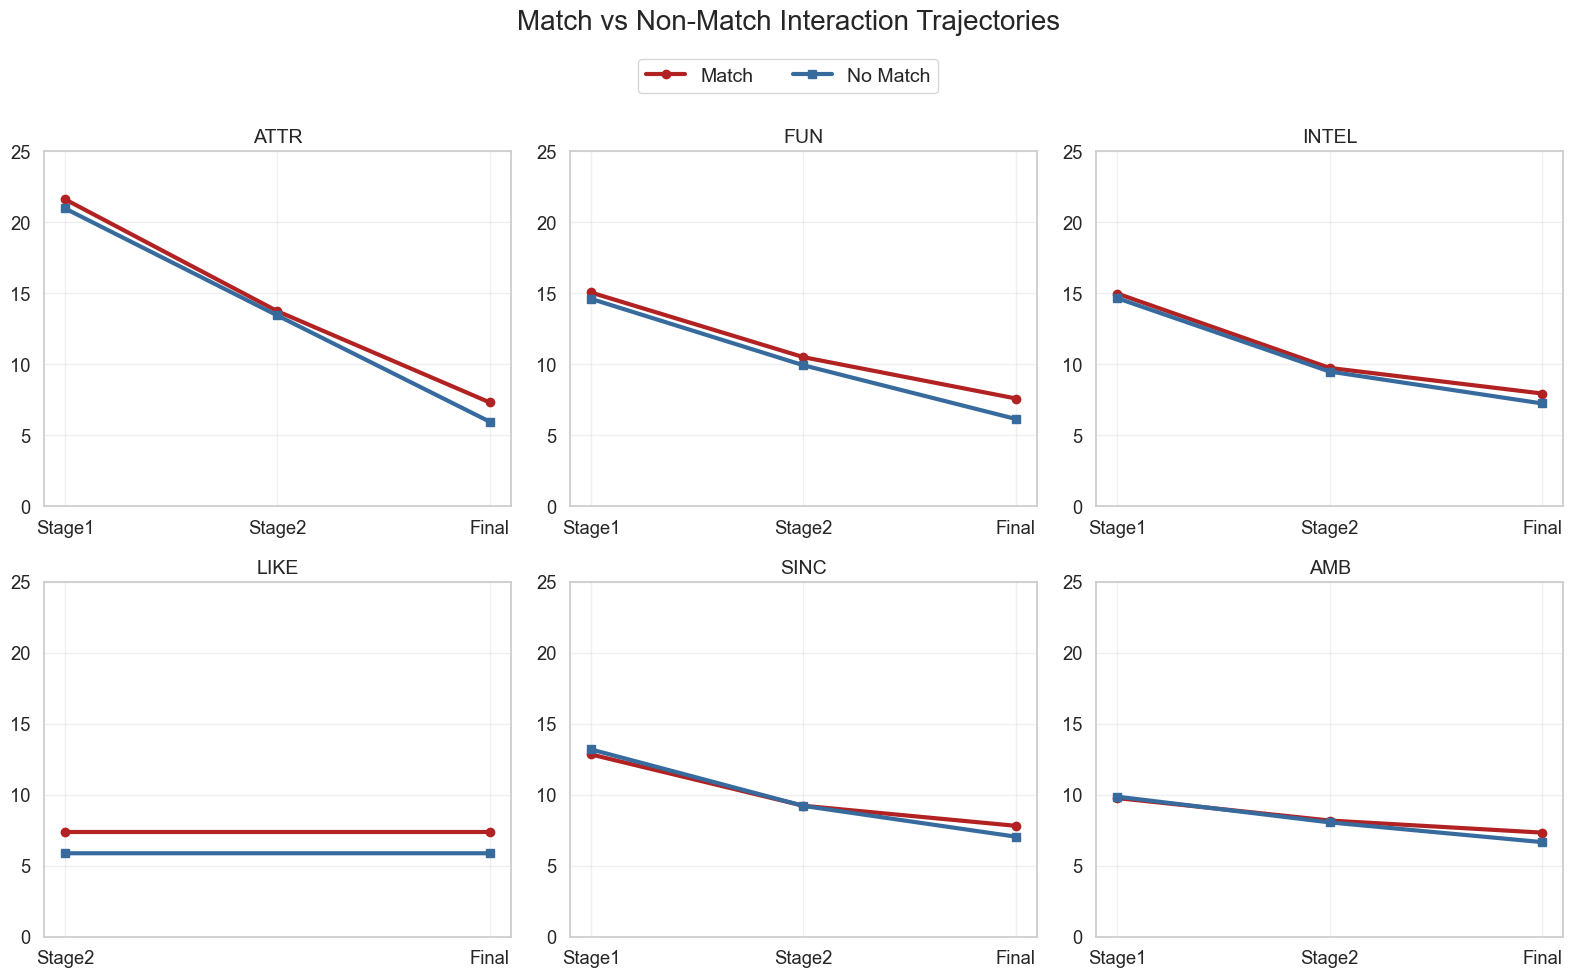

In [18]:
# （Match vs Non-match 轨迹）
def plot_match_vs_nonmatch_trajectory(std, bases):
    stages = ["Stage1", "Stage2", "Final"]

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i, b in enumerate(bases):
        ax = axes[i]

        match_df = std[std['match'] == 1]
        nonmatch_df = std[std['match'] == 0]

        # Match dyads
        m_vals = [
            match_df[f"{b}_Stage1"].mean(),
            match_df[f"{b}_Stage2"].mean(),
            match_df[f"{b}_Final"].mean()
        ]

        # Non-match dyads
        nm_vals = [
            nonmatch_df[f"{b}_Stage1"].mean(),
            nonmatch_df[f"{b}_Stage2"].mean(),
            nonmatch_df[f"{b}_Final"].mean()
        ]

        # ---- 使用指定的颜色 ----
        ax.plot(
            stages, m_vals, marker="o", linewidth=3,
            color="#b22222", label="Match (Yes)"
        )
        ax.plot(
            stages, nm_vals, marker="s", linewidth=3,
            color="#376b9e", label="No Match"
        )

        ax.set_title(b.upper(), fontsize=14)
        ax.set_ylim(0, 25)
        ax.grid(True, alpha=0.3)

    # 统一图例
    fig.legend(
        ["Match", "No Match"],
        loc="upper center",
        ncol=2,
        fontsize=14,
        bbox_to_anchor=(0.5, 0.94)
    )
    fig.suptitle("Match vs Non-Match Interaction Trajectories", fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

plot_match_vs_nonmatch_trajectory(std, bases)


**情感差异热力图（Heatmap of Score Shifts）**

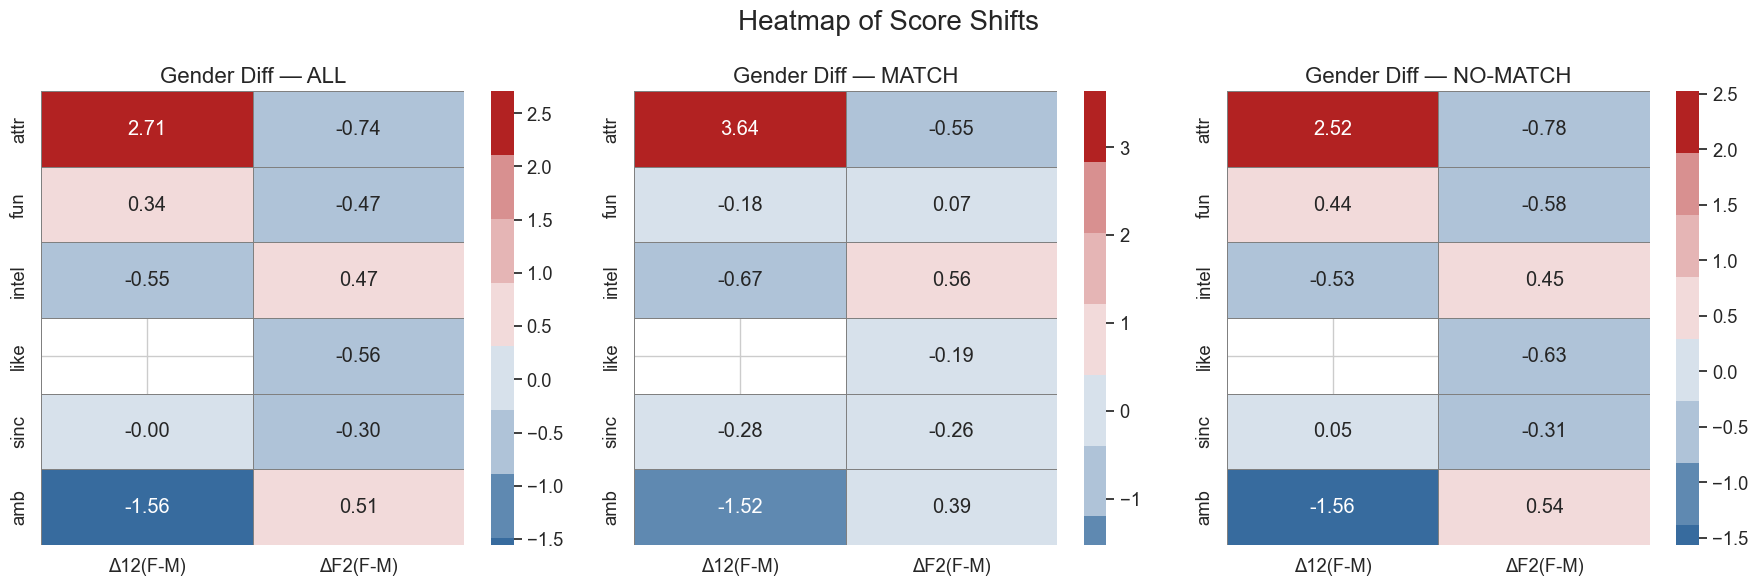

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. Blue-Pink SCI Color Palette
# =========================
palette = ["#104e8b","#376b9e","#5f89b1","#afc3d8",
           "#d7e1eb","#f2dada","#e5b5b5","#d89090","#b22222"]

cmap = sns.color_palette(palette, as_cmap=True)

# =========================
# 2. Gender Difference Function
# =========================

def compute_gender_diff(std_sub):
    df = pd.DataFrame(index=bases, columns=["Δ12(F-M)", "ΔF2(F-M)"], dtype=float)

    for b in bases:
        d12 = std_sub[f"{b}_Stage2"] - std_sub[f"{b}_Stage1"]
        dF2 = std_sub[f"{b}_Final"] - std_sub[f"{b}_Stage2"]

        df.loc[b, "Δ12(F-M)"] = d12[std_sub["gender"]==0].mean() - d12[std_sub["gender"]==1].mean()
        df.loc[b, "ΔF2(F-M)"] = dF2[std_sub["gender"]==0].mean() - dF2[std_sub["gender"]==1].mean()

    return df

# =========================
# 3. Compute ALL / MATCH / NO-MATCH
# =========================

gender_all   = compute_gender_diff(std)
gender_match = compute_gender_diff(std[std["match"]==1])
gender_nomat = compute_gender_diff(std[std["match"]==0])

# =========================
# 4. Draw 1×3 subplot
# =========================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

titles = ["Gender Diff — ALL", "Gender Diff — MATCH", "Gender Diff — NO-MATCH"]
datasets = [gender_all, gender_match, gender_nomat]

for ax, title, df in zip(axes, titles, datasets):
    sns.heatmap(df, annot=True, cmap=cmap, center=0, fmt=".2f",
                linewidths=0.5, linecolor="gray", ax=ax)
    ax.set_title(title, fontsize=16)

fig.suptitle("Heatmap of Score Shifts", fontsize=20)

plt.tight_layout()
plt.show()
